In [182]:
import time 
import pickle

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

from matplotlib.colors import Normalize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

np.random.seed(0)
torch.manual_seed(0)

In [183]:
path = 'Data/ui_data.csv'  
data = pd.read_csv(path)
print(data.shape)

(1984, 10)


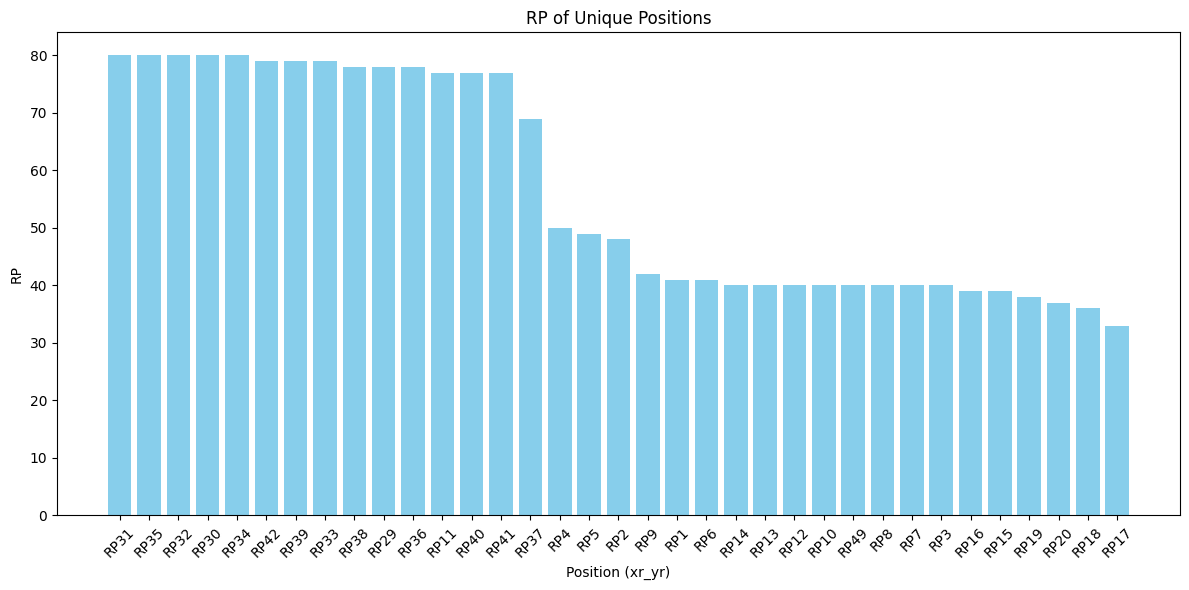

In [184]:
# Step 2: Count the frequency of each unique position
frequency = data['reference_point'].value_counts()

# If you want to reset the index and get a DataFrame
frequency_df = frequency.reset_index()
frequency_df.columns = ['reference_point', 'frequency']

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(frequency_df['reference_point'], frequency_df['frequency'], color='skyblue')
plt.xlabel('Position (xr_yr)')
plt.ylabel('RP')
plt.title('RP of Unique Positions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [185]:
data['rssi_ap_dosen'].unique()

array([ nan, -96., -94., -95., -92., -97., -90., -89., -91., -93., -86.,
       -88., -87., -81., -82., -83., -84., -85., -79., -80., -78., -77.,
       -75., -70., -71., -72., -73., -74., -63., -64., -62., -76.])

In [186]:
data['rssi_ap_digilab'].unique()

array([-64., -63., -65., -62., -61., -60., -67., -71.,  nan, -70., -66.,
       -68., -69., -74., -75., -72., -73., -59., -57., -58., -43., -42.,
       -44., -45., -41., -39., -50., -51., -46., -47., -52., -53., -54.,
       -55., -56., -76., -77., -81., -80., -79., -78., -49., -48., -83.])

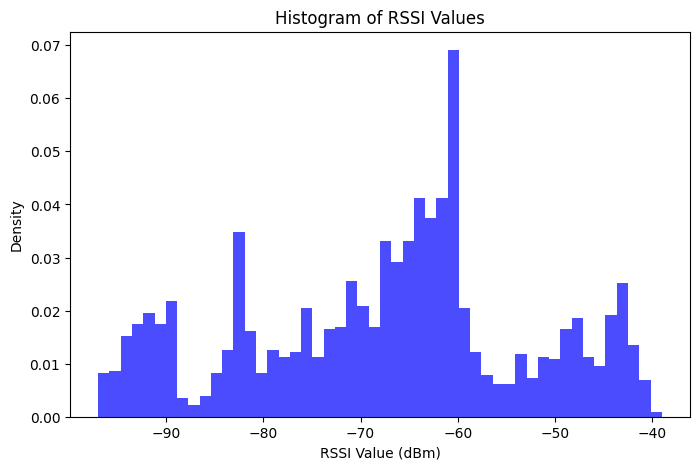

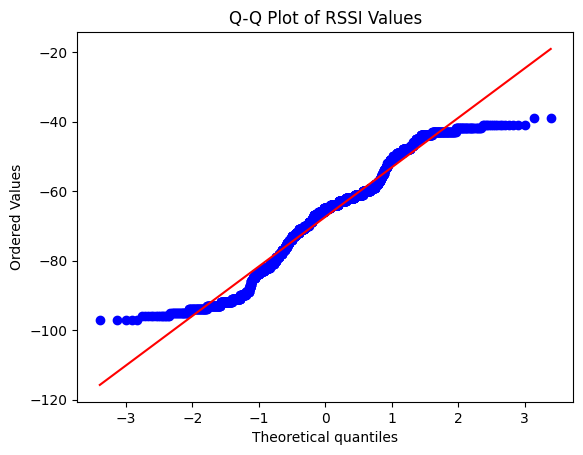

RSSI Skewness: -0.1637
RSSI Kurtosis: -0.7052


In [187]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import skew, kurtosis

# Select RSSI columns (replace with actual column names from your dataset)
rssi_digilab = data["rssi_ap_digilab"]
rssi_dosen = data["rssi_ap_dosen"]

rssi_digilab = rssi_digilab[rssi_digilab > -200]
rssi_dosen = rssi_dosen[rssi_dosen > -200]

# Combine both RSSI columns for analysis
rssi_values = np.concatenate([rssi_digilab, rssi_dosen])

# 1️⃣ Histogram (Check RSSI Distribution)
plt.figure(figsize=(8, 5))
plt.hist(rssi_values, bins=50, color='blue', alpha=0.7, density=True)
plt.xlabel("RSSI Value (dBm)")
plt.ylabel("Density")
plt.title("Histogram of RSSI Values")
plt.show()

# 2️⃣ Q-Q Plot (Check for Normality)
stats.probplot(rssi_values, dist="norm", plot=plt)
plt.title("Q-Q Plot of RSSI Values")
plt.show()

# 3️⃣ Skewness & Kurtosis (Numerical Analysis)
rssi_skewness = skew(rssi_values)
rssi_kurtosis = kurtosis(rssi_values)

print(f"RSSI Skewness: {rssi_skewness:.4f}")  # >0 means right-skewed, <0 means left-skewed
print(f"RSSI Kurtosis: {rssi_kurtosis:.4f}")  # >3 means heavy-tailed (outliers)


In [188]:
# Fill missing RSSI values
data['rssi_ap_digilab'] = data['rssi_ap_digilab'].fillna(-200)
data['rssi_ap_dosen'] = data['rssi_ap_dosen'].fillna(-200)

In [189]:
ap_coordinates = {
    'DTE Staff (Digilab)': (867, 1122),
    'DTE Staff (Dosen)': (2454, 520)
}

In [190]:
data = data[~data['reference_point'].isin(['RP49', 'RP74'])]

# Ensure the relative_position column exists with a default numeric value (-1 for unassigned)
data['relative_position'] = -1  # Using -1 to indicate unassigned values initially

# Define reference points that should be assigned a relative position of 0
zero_rps = (
    list(range(1, 21)) +   # RP1-20
    list(range(53, 57)) +  # RP53-56
    list(range(58, 62)) +  # RP58-61
    list(range(63, 65)) +  # RP63-64
    list(range(66, 73)) +  # RP66-72
    list(range(75, 78)) +  # RP75-77
    list(range(80, 89)) +  # RP80-88
    list(range(113, 116)) +  # RP113-115
    list(range(118, 121)) +  # RP118-120
    list(range(93, 96)) +
    list(range(98, 101)) +
    list(range(103, 106)) +
    list(range(108, 111)) 
)

# Define reference points that should be assigned a relative position of 1
one_rps = list(range(28, 43)) + [89, 90]  # RP28-42 and RP89-90


# Convert lists to sets for faster lookup
zero_rp_set = {f'RP{i}' for i in zero_rps}
one_rp_set = {f'RP{i}' for i in one_rps}

# Apply conditions to assign relative_position
data['relative_position'] = data['reference_point'].apply(
    lambda rp: 0 if rp in zero_rp_set else (1 if rp in one_rp_set else -1)
)

# Convert to integer type to ensure it's numeric
data['relative_position'] = data['relative_position'].astype(int)

# Check unique values to ensure no -1 remains
print("Unique values in relative_position:", data['relative_position'].unique())

# Check the first few rows to confirm the relative_position column was added correctly
print(data[['reference_point', 'relative_position']].head())

Unique values in relative_position: [0 1]
  reference_point  relative_position
0             RP1                  0
1             RP1                  0
2             RP1                  0
3             RP1                  0
4             RP1                  0


In [191]:
# Convert the 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'])
# Convert to seconds since the epoch
data['time_numeric'] = data['time'].apply(lambda x: x.time())

In [192]:
# Define the mapping dictionary
bssid_mapping = {
    '70:a7:41:dc:8e:55': 1, # dosen staff
    '72:a7:41:9c:8e:55': 2, # dosen student
    '70:a7:41:dc:77:cd': 3, # digi staff
    '72:a7:41:9c:77:cd': 4 # digi student
}

In [193]:
data['bssid'] = data['bssid'].map(bssid_mapping)
print(data[['bssid', 'bssid']].head())


   bssid  bssid
0      4      4
1      3      3
2      4      4
3      4      4
4      3      3


In [194]:
# Assuming 'reference_point' is your column name in the DataFrame
data['reference_point'] = data['reference_point'].str.replace('RP', '').astype(int)

# Check the result
print(data['reference_point'])

0        1
1        1
2        1
3        1
4        1
        ..
1979    31
1980    31
1981    31
1982    31
1983    31
Name: reference_point, Length: 1944, dtype: int32


In [195]:
data.sample(10)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric
18,2024-10-17 08:43:00.729278400+00:00,1,9,DTE Staff,3,11,300,1368,-62.0,-200.0,0,08:43:00.729278
1740,2024-10-23 09:04:13.464533600+00:00,33,20,DTE Staff,3,11,1449,1037,-49.0,-200.0,1,09:04:13.464533
465,2024-10-17 10:22:58.943280900+00:00,29,9,DTE Staff,2,1,989,1037,-200.0,-90.0,1,10:22:58.943280
1258,2024-10-23 07:12:42.097023+00:00,42,7,DTE Staff,2,1,2454,1202,-200.0,-72.0,1,07:12:42.097023
1003,2024-10-23 04:09:54.198929900+00:00,19,1,DTE Student,4,11,989,1948,-78.0,-200.0,0,04:09:54.198929
799,2024-10-23 03:11:42.328934200+00:00,13,13,DTE Student,4,11,759,1749,-76.0,-200.0,0,03:11:42.328934
1399,2024-10-23 07:33:46.142009700+00:00,40,3,DTE Staff,2,1,2224,1202,-200.0,-87.0,1,07:33:46.142009
522,2024-10-17 10:30:26.317919800+00:00,30,4,DTE Staff,3,11,989,1202,-43.0,-200.0,1,10:30:26.317919
385,2024-10-17 10:07:00.944091800+00:00,9,19,DTE Staff,3,11,529,1948,-60.0,-200.0,0,10:07:00.944091
161,2024-10-17 09:20:34.758345800+00:00,4,14,DTE Student,4,11,300,1948,-64.0,-200.0,0,09:20:34.758345


In [196]:
# Save the final dataframe
data.to_csv('data_preprocessed.csv', index=False)
print(f"Data saved to {'data_preprocessed.csv'}")

Data saved to data_preprocessed.csv


In [197]:
def encode_and_save_labels(data, column_name, encoder_file_name='label_encoder.pkl'):
    # Initialize the LabelEncoder
    le = LabelEncoder()
    
    # Fit and transform the data
    encoded_values = le.fit_transform(data[column_name])
    
    # Replace the original column with encoded values
    data[column_name] = encoded_values
    
    # Save the encoder to a file
    with open(encoder_file_name, 'wb') as file:
        pickle.dump(le, file)
    
    print(f"Encoded {column_name} and saved encoder to {encoder_file_name}")
    
    return data

def decode_labels(data, column_name, encoder_file_name='label_encoder.pkl'):
    # Load the encoder from the file
    with open(encoder_file_name, 'rb') as file:
        le = pickle.load(file)
    
    # Transform the encoded values back to original labels
    decoded_values = le.inverse_transform(data[column_name])
    
    # Replace the encoded column with decoded values
    data[column_name] = decoded_values
    
    print(f"Decoded {column_name} using encoder from {encoder_file_name}")
    
    return data

def decode_predictions(y_pred, encoder_file_name='label_encoder.pkl'):
    # Load the encoder from the file
    with open(encoder_file_name, 'rb') as file:
        le = pickle.load(file)
    
    # Transform the encoded predictions back to original labels
    decoded_predictions = le.inverse_transform(y_pred)
    
    print(f"Decoded predictions using encoder from {encoder_file_name}")
    
    return decoded_predictions

## Scaling using Robust Scaler


In [198]:
print("Columns in DataFrame:", data.columns)
print("Shape of DataFrame:", data.shape)

Columns in DataFrame: Index(['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel',
       'xr', 'yr', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position',
       'time_numeric'],
      dtype='object')
Shape of DataFrame: (1944, 12)


In [199]:
df = data.iloc[:, [1, 2, 4, 5, 8 , 9, 10]]
print("\nColumns in X:", df.columns.tolist())

df = encode_and_save_labels(df, 'reference_point')
df = df.rename(columns={'reference_point': 'label'})


Columns in X: ['reference_point', 'iteration', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']
Encoded reference_point and saved encoder to label_encoder.pkl


C:\Users\laure\AppData\Local\Temp\ipykernel_3652\2956030956.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = encoded_values


In [200]:
df

,label,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,relative_position
0,0,3,4,11,-64.0,-200.0,0
1,0,1,3,11,-63.0,-200.0,0
2,0,1,4,11,-63.0,-200.0,0
3,0,2,4,11,-64.0,-200.0,0
4,0,2,3,11,-65.0,-200.0,0
...,...,...,...,...,...,...,...
1979,22,19,2,1,-200.0,-83.0,1
1980,22,20,4,11,-43.0,-200.0,1
1981,22,20,3,11,-43.0,-200.0,1
1982,22,20,1,1,-200.0,-83.0,1


### Are there overlapping points?

In [201]:
binned_data = df.copy()
binned_data.iloc[:, :-1] = np.round(binned_data.iloc[:, :-1]) 
overlapping_points = binned_data.groupby(list(binned_data.columns[:-1]))['label'].nunique()
overlapping_points = overlapping_points[overlapping_points > 1]
overlapping_data = binned_data.set_index(list(binned_data.columns[:-1])).loc[overlapping_points.index]

overlapping_data

,,,,,,relative_position
label,iteration,bssid,channel,rssi_ap_digilab,rssi_ap_dosen,


In [202]:
# delete overlapping data 
non_overlapping_mask = ~binned_data.set_index(list(binned_data.columns[:-1])).index.isin(overlapping_points.index)
df = df[non_overlapping_mask]
df.shape

(1944, 7)

## Regression Model

In [203]:
X = data.iloc[:, [1, 4, 5, 8 , 9, 10]]
y = data.iloc[:, [6, 7]] # Selecting reference_point (ap_name), xr (x), yr (y)

In [204]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']
Columns in y: ['xr', 'yr']


In [205]:
print(X.head())
print(X.dtypes)

   reference_point  bssid  channel  rssi_ap_digilab  rssi_ap_dosen  \
0                1      4       11            -64.0         -200.0   
1                1      3       11            -63.0         -200.0   
2                1      4       11            -63.0         -200.0   
3                1      4       11            -64.0         -200.0   
4                1      3       11            -65.0         -200.0   

   relative_position  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
reference_point        int32
bssid                  int64
channel                int64
rssi_ap_digilab      float64
rssi_ap_dosen        float64
relative_position      int32
dtype: object


In [206]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, np.ndarray): self.features = torch.tensor(features, dtype=torch.float32)
        else: self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    

regression_data_scaled = RobustScaler().fit_transform(X)

dataset = CustomDataset(regression_data_scaled, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

dataset = CustomDataset(regression_data_scaled, y)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [207]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'bssid', 'channel', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position']
Columns in y: ['xr', 'yr']


In [208]:
# Import necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Assuming X and y are preprocessed and split-ready
# Ensure y is a numpy array
y = np.array(y)  # Convert to numpy array if y is a pandas DataFrame or Series

# Step 1: Split the dataset into 70% training, 30% remaining (not final test set)
X_train, X_unused, y_train, y_unused = train_test_split(regression_data_scaled, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

# Step 2: Use 100% of the dataset as the test set
X_test = regression_data_scaled  # Full dataset as test set
y_test = y  # Full dataset labels

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]} (Full Dataset)")

Training set size: 1196
Test set size: 1944 (Full Dataset)


In [209]:
print(f"Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")


Training samples: 1196, Features: 6


In [210]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    max_depth=6,  # Increase depth for more complex patterns
    learning_rate=0.05,  # Reduce step size for better accuracy
    n_estimators=500  # More trees for better generalization
)

# Use MultiOutputRegressor to handle multiple targets
multi_xgb = MultiOutputRegressor(xgb_model)

In [211]:
# Define hyperparameters for tuning
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 4, 5],
    'estimator__learning_rate': [0.01, 0.1, 0.3]
}

In [212]:
# def remove_outliers_before_training(X, y, threshold=1000):
#     """Remove samples where MSE is an outlier before training the model."""
#     # Predict rough initial values using a simple model to estimate errors
#     temp_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))
#     temp_model.fit(X, y)
#     y_pred = temp_model.predict(X)
    
#     # Compute errors
#     mse = np.mean((y - y_pred)**2, axis=1)
    
#     # Keep only samples with MSE below the threshold
#     mask = mse < threshold
#     return X[mask], y[mask]

In [213]:
X_train, y_train = remove_outliers_before_training(X_train, y_train, threshold=1000)


In [214]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(multi_xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constr...
                                                                   max_depth=6,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=500,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=42, ...)),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.01, 0.1, 0.3],
                         'estimator__max_depth': [3, 4, 5],
                         'estimator__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [215]:
# Print the best parameters
print("Best parameters found by grid search:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Get the best model
best_model = grid_search.best_estimator_

# Print all hyperparameters of the best model
print("\nAll hyperparameters of the best model:")
for i, estimator in enumerate(best_model.estimators_):
    print(f"\nEstimator for dimension {i+1} ({'x' if i==0 else 'y' if i==1 else 'z'}):")
    # for param, value in estimator.get_params().items():
    #     print(f"  {param}: {value}")

Best parameters found by grid search:
estimator__learning_rate: 0.3
estimator__max_depth: 3
estimator__n_estimators: 300

All hyperparameters of the best model:

Estimator for dimension 1 (x):

Estimator for dimension 2 (y):


In [216]:
# Make predictions
y_pred = best_model.predict(X_test)

In [217]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"\nOverall Mean Squared Error: {mse}")

# Calculate and print MSE for each coordinate
for i, coord in enumerate(['x', 'y']):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    print(f"MSE for {coord}: {mse}")


Overall Mean Squared Error: 19.015153884887695
MSE for x: 1.617358513783529e-08
MSE for y: 38.03030776977539


In [218]:
%pip install opencv

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for opencv


In [219]:
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2
# from matplotlib.colors import Normalize
# from sklearn.metrics import mean_squared_error

# def plot_2d_ap_positions_with_floorplan(y_true, y_pred, floorplan_path, real_to_pixel_scale=None):
#     # Load the floor plan image
#     floorplan = cv2.imread(floorplan_path)
#     floorplan = cv2.cvtColor(floorplan, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

#     # Get image dimensions
#     img_height, img_width, _ = floorplan.shape

#     # If a scaling factor is provided, transform real-world coordinates to pixel space
#     if real_to_pixel_scale:
#         y_true = y_true * real_to_pixel_scale
#         y_pred = y_pred * real_to_pixel_scale

#     # Flip only the Y-coordinates of the predictions
#     y_pred[:, 1] = img_height - y_pred[:, 1]
#     y_true[:, 1] = img_height - y_true[:, 1]  # Optional: If ground truth also needs flipping

#     # Calculate MSE for each point
#     mse = np.mean((y_true - y_pred) ** 2, axis=1)

#     print(f"Number of predictions: {len(y_pred)}")

#     # Create the 2D plot with the floor plan as the background
#     plt.figure(figsize=(12, 10))
#     plt.imshow(floorplan, extent=[0, img_width, img_height, 0])  # Floor plan remains in place

#     # Plot ground truth positions in red
#     plt.scatter(y_true[:, 0], y_true[:, 1], 
#                 c='red', marker='o', s=100, alpha=1, label='Ground Truth')

#     # Adjust normalization range based on the MSE values
#     norm = Normalize(vmin=mse.min(), vmax=mse.max())

#     # Plot predicted positions with color based on MSE
#     scatter = plt.scatter(y_pred[:, 0], y_pred[:, 1],
#                           c=mse, norm=norm, cmap='plasma', s=50, alpha=0.9, label='Predicted')

#     # Add colorbar
#     cbar = plt.colorbar(scatter)
#     cbar.set_label('Mean Squared Error')

#     # Calculate overall MSE
#     overall_mse = mean_squared_error(y_true, y_pred)

#     plt.xlabel('X Position')
#     plt.ylabel('Y Position')
#     plt.legend()
#     plt.title(f'AP Positions on Floor Plan - Overall MSE: {overall_mse:.4f}')

#     plt.tight_layout()
#     plt.show()

# # Example usage
# floorplan_path = "Data/floorplan.png"  # Update this to your floorplan image path
# plot_2d_ap_positions_with_floorplan(y_test, y_pred, floorplan_path)


In [220]:
predicted_df = pd.DataFrame({
    'xp': y_pred[:, 0],  # Predicted x-coordinate
    'yp': y_pred[:, 1]   # Predicted y-coordinate
})

merged_data = data.copy()

# Ensure the number of rows match before merging
merged_data = merged_data.iloc[:len(y_pred)]  # Trim if necessary

# Add predicted coordinates to the dataset
merged_data[['xp', 'yp']] = predicted_df.values

In [221]:
merged_data.shape

(1944, 14)

In [222]:
merged_data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp
718,2024-10-23 02:53:02.765489+00:00,11,16,DTE Staff,1,1,759,1368,-200.0,-94.0,0,02:53:02.765489,759.000061,1365.985596
798,2024-10-23 03:11:25.724209+00:00,13,12,DTE Staff,3,11,759,1749,-75.0,-200.0,0,03:11:25.724209,759.000061,1749.220703
334,2024-10-17 09:57:50.159182+00:00,8,13,DTE Staff,3,11,529,1749,-68.0,-200.0,0,09:57:50.159182,529.000061,1748.168945
12,2024-10-17 08:41:46.015794800+00:00,1,6,DTE Staff,3,11,300,1368,-64.0,-200.0,0,08:41:46.015794,300.000092,1367.888062
617,2024-10-17 10:42:03.462011900+00:00,37,8,DTE Staff,3,11,1908,1037,-56.0,-200.0,1,10:42:03.462011,1907.999878,1038.037476


In [223]:
data['xr'].unique()

array([ 300,  529,  989, 1908,  759, 1678, 2454, 2224, 1449, 1219],
      dtype=int64)

In [224]:
merged_data['xp'].unique()


array([ 300.0001 ,  529.00006,  989.     , 1907.9999 ,  759.00006,
       1677.9999 , 2453.9998 , 2223.9998 , 1448.9999 , 1218.9999 ],
      dtype=float32)

In [225]:
data['yr'].unique()

array([1368, 1567, 1749, 1948, 2130, 1037, 1202], dtype=int64)

In [226]:
merged_data['yp'].unique()

array([1367.9985, 1367.8881, 1368.2008, 1368.2681, 1368.1583, 1367.9218,
       1367.993 , 1368.1028, 1368.0238, 1368.1335, 1567.313 , 1567.3685,
       1567.2032, 1566.3413, 1567.4783, 1566.1846, 1565.6927, 1565.7008,
       1566.0878, 1566.3206, 1567.1168, 1567.2627, 1748.9968, 1748.8401,
       1749.7988, 1750.0316, 1947.7842, 1947.9409, 1943.1389, 1947.3188,
       1950.161 , 1948.5126, 1950.0813, 1949.6469, 2131.9385, 2132.685 ,
       2130.1702, 2129.9375, 2126.1094, 2126.266 , 2129.1304, 2123.1646,
       2130.1865, 2129.1384, 2128.5386, 2132.124 , 2132.7917, 1369.4696,
       1368.5823, 1366.894 , 1365.782 , 1363.086 , 1364.9543, 1367.1301,
       1367.5586, 1370.551 , 1369.8285, 1309.4363, 1313.2734, 1568.6278,
       1567.7405, 1566.7595, 1567.4609, 1567.3285, 1567.6469, 1568.0619,
       1568.0254, 1566.7275, 1567.5969, 1564.1384, 1564.5591, 1564.4493,
       1572.2557, 1569.8522, 1749.1499, 1748.0504, 1747.2816, 1748.7838,
       1748.2626, 1747.1608, 1746.0487, 1749.3848, 

In [227]:
# Convert xp and yp to integers based on their decimal value
merged_data['xp'] = np.where(merged_data['xp'] % 1 >= 0.5, np.ceil(merged_data['xp']), np.floor(merged_data['xp'])).astype(int)
merged_data['yp'] = np.where(merged_data['yp'] % 1 >= 0.5, np.ceil(merged_data['yp']), np.floor(merged_data['yp'])).astype(int)

# Verify conversion
print(merged_data[['xp', 'yp']].head())  # Check the first few rows


    xp    yp
0  300  1368
1  300  1368
2  300  1368
3  300  1368
4  300  1368


In [228]:
# Save the new dataset to a CSV file
merged_data.to_csv('Data/please.csv', index=False)

print("New CSV file 'please.csv' saved successfully!")

New CSV file 'please.csv' saved successfully!
